In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
os.listdir(r"F:\UNIVERSITY STUDY\AI\dataset\FCN\annotations\trimaps")[-5:]

['yorkshire_terrier_95.png',
 'yorkshire_terrier_96.png',
 'yorkshire_terrier_97.png',
 'yorkshire_terrier_98.png',
 'yorkshire_terrier_99.png']

In [4]:
img=tf.io.read_file(r"F:\UNIVERSITY STUDY\AI\dataset\FCN\annotations\trimaps\yorkshire_terrier_99.png")

In [5]:
img=tf.image.decode_png(img)

In [6]:
img.shape

TensorShape([358, 500, 1])

In [7]:
img=tf.squeeze(img)#将图像当中一维的数据缩减掉，并没有什么用

In [8]:
img.shape

TensorShape([358, 500])

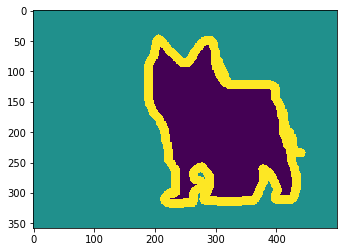

In [9]:
#现在进行绘图
plt.imshow(img)

In [10]:
img=tf.io.read_file(r"F:\UNIVERSITY STUDY\AI\dataset\FCN\images\yorkshire_terrier_99.jpg")
img=tf.image.decode_jpeg(img)

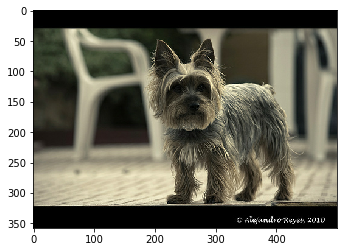

In [11]:
plt.imshow(img)




In [12]:
import glob
images=glob.glob(r"F:\UNIVERSITY STUDY\AI\dataset\FCN\images\*.jpg")

In [13]:
images[:3]

['F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\images\\Abyssinian_1.jpg',
 'F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\images\\Abyssinian_10.jpg',
 'F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\images\\Abyssinian_100.jpg']

In [14]:
len(images)

7390

In [15]:
#然后读取目标图像
anno=glob.glob(r"F:\UNIVERSITY STUDY\AI\dataset\FCN\annotations\trimaps\*.png")

In [16]:
anno[:3]

['F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\annotations\\trimaps\\Abyssinian_1.png',
 'F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\annotations\\trimaps\\Abyssinian_10.png',
 'F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\annotations\\trimaps\\Abyssinian_100.png']

In [17]:
anno[-5]

'F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\annotations\\trimaps\\yorkshire_terrier_95.png'

In [18]:
images[:3]

['F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\images\\Abyssinian_1.jpg',
 'F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\images\\Abyssinian_10.jpg',
 'F:\\UNIVERSITY STUDY\\AI\\dataset\\FCN\\images\\Abyssinian_100.jpg']

In [19]:
#现在对读取进来的数据进行制作batch
np.random.seed(2019)
index=np.random.permutation(len(images))

In [20]:
images=np.array(images)[index]
anno=np.array(anno)[index]

In [21]:
#创建dataset
dataset=tf.data.Dataset.from_tensor_slices((images,anno))

In [22]:
test_count=int(len(images)*0.2)
train_count=len(images)-test_count

In [27]:
data_train=dataset.skip(test_count)
data_test=dataset.take(test_count)

In [28]:
def read_jpg(path):
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img,channels=3)
    return img

In [29]:
def read_png(path):
    img=tf.io.read_file(path)
    img=tf.image.decode_png(img,channels=1)
    return img

In [30]:
#现在编写归一化的函数
def normal_img(input_images,input_anno):
    input_images=tf.cast(input_images,tf.float32)
    input_images=input_images/127.5-1
    input_anno-=1
    return input_images,input_anno

In [31]:
#加载函数
def load_images(input_images_path,input_anno_path):
    input_image=read_jpg(input_images_path)
    input_anno=read_png(input_anno_path)
    input_image=tf.image.resize(input_image,(224,224))
    input_anno=tf.image.resize(input_anno,(224,224))
    return normal_img(input_image,input_anno)

In [32]:
data_train=data_train.map(load_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_test=data_test.map(load_images,num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [33]:
#现在开始batch的制作
BATCH_SIZE=3#根据显存进行调整
data_train=data_train.repeat().shuffle(100).batch(BATCH_SIZE)

In [34]:
data_test=data_test.batch(BATCH_SIZE)

In [35]:
data_train

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

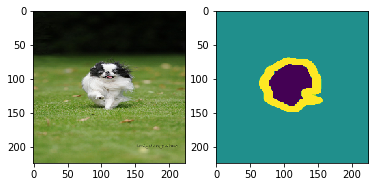

In [36]:
for img,anno in data_train.take(1):
    #take出来的是一个batch的图像
    
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[0]))

In [37]:
#现在数据终于被我们所准备好了，现在终于可以开始搭建神经网络的模型了。
#在搭建模型的时候，我们使用了预训练网络进行迁移学习，同时由于FCN采取了跳级连接，因此我们需要得到预训练模型当中中间层的输出


In [38]:
conv_base=tf.keras.applications.VGG16(weights='imagenet',
                                     input_shape=(224,224,3),
                                     include_top=False)

In [39]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [40]:
#现在我们就可以拿到block5_conv3的输出，进行跳级连接了，连接之后再上采样5_
conv_base.get_layer("block5_conv3").output

<tf.Tensor 'block5_conv3_1/Identity:0' shape=(None, 14, 14, 512) dtype=float32>

In [41]:
#现在创建子model用于继承conv_base的权重，用于获取模型的中间输出
#使用这个方法居然能够继承，而没有显式的指定到底继承哪一个模型，确实神奇
#确实是可以使用这个的，这个方法就是在模型建立完之后再进行的调用
#这样就会继续自动继承之前的网络结构
#而如果定义
sub_model=tf.keras.models.Model(inputs=conv_base.input,
                               outputs=conv_base.get_layer('block5_conv3').output)

In [42]:
sub_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [43]:
#现在创建多输出模型,三个output
layer_names=[
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
    'block5_pool'
]

In [44]:
#得到这几个曾输出的列表，为了方便就直接使用列表推倒式了，一句话搞定
layers_output=[conv_base.get_layer(layer_name).output for layer_name in layer_names]

In [45]:
layers_output

[<tf.Tensor 'block5_conv3_1/Identity:0' shape=(None, 14, 14, 512) dtype=float32>,
 <tf.Tensor 'block4_conv3_1/Identity:0' shape=(None, 28, 28, 512) dtype=float32>,
 <tf.Tensor 'block3_conv3_1/Identity:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'block5_pool_1/Identity:0' shape=(None, 7, 7, 512) dtype=float32>]

In [46]:
#创建一个多输出模型，这样一张图片经过这个网络之后，就会有多个输出值了
#不过输出值虽然有了，怎么能够进行跳级连接呢？
multiout_model=tf.keras.models.Model(inputs=conv_base.input,
                               outputs=layers_output)

In [47]:
multiout_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [48]:
multiout_model.trainable=False

In [49]:
inputs=tf.keras.layers.Input(shape=(224,224,3))
#这个多输出模型会输出多个值，因此前面用多个参数来接受即可。
out_block5_conv3,out_block4_conv3,out_block3_conv3,out=multiout_model(inputs)
#现在将最后一层输出的结果进行上采样,然后分别和中间层多输出的结果进行相加，实现跳级连接
#这里表示有512个卷积核，filter的大小是3*3
x1=tf.keras.layers.Conv2DTranspose(512,3,
                                   strides=2,
                                   padding='same',
                                   activation='relu')(out)
#上采样之后再加上一层卷积来提取特征
x1=tf.keras.layers.Conv2D(512,3,padding='same',
                                   activation='relu')(x1)
#与多输出结果的倒数第二层进行相加，shape不变
x2=tf.add(x1,out_block5_conv3)
#x2进行上采样
x2=tf.keras.layers.Conv2DTranspose(512,3,
                                   strides=2,
                                   padding='same',
                                   activation='relu')(x2)
#直接拿到x3，不使用
x3=tf.add(x2,out_block4_conv3)
#x3进行上采样
x3=tf.keras.layers.Conv2DTranspose(256,3,
                                   strides=2,
                                   padding='same',
                                   activation='relu')(x3)
#增加卷积提取特征
x3=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(x3)
x4=tf.add(x3,out_block3_conv3)
#x4还需要再次进行上采样，得到和原图一样大小的图片，再进行分类
x5=tf.keras.layers.Conv2DTranspose(128,3,
                                   strides=2,
                                   padding='same',
                                   activation='relu')(x4)
#继续进行卷积提取特征
x5=tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(x5)

In [50]:
x5.shape

TensorShape([None, 112, 112, 128])

In [51]:
#最后一步，图像还原
preditcion=tf.keras.layers.Conv2DTranspose(3,3,
                                   strides=2,
                                   padding='same',
                                   activation='softmax')(x5)

In [52]:
preditcion.shape

TensorShape([None, 224, 224, 3])

In [53]:
model=tf.keras.models.Model(
inputs=inputs,
outputs=preditcion
)

In [54]:
model.summary()#因为有跳级结构，因此这个函数不能够进行很好的表示

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 14, 14, 512) 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 14, 14, 512)  2359808     model_1[1][3]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 512)  2359808     conv2d_transpose[0][0]           
____________________________________________________________________________________________

In [50]:
model.compile(
optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']#这个参数应该是用来打印正确率用的，现在终于理解啦啊
)

In [51]:
model.fit(data_train,
         epochs=1,
         steps_per_epoch=train_count//BATCH_SIZE,
         validation_data=data_test,
         validation_steps=train_count//BATCH_SIZE)

Train for 1970 steps, validate for 1970 steps
1970/1970 [==============================] - 3233s 2s/step - loss: 0.3271 - acc: 0.8699 - val_loss: 0.0661 - val_acc: 0.8905


In [52]:
#由于训练这个模型花费了太多时间了，因此我将这个模型进行保存
#能够保存模型的1.权重2.模型的配置3.优化器的配置
model.save('FCN_model.h5')

In [55]:
#如何使用这个保存的模型呢？
new_model=tf.keras.models.load_model('FCN_model.h5')
#查看这个模型的架构：
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 14, 14, 512) 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 14, 14, 512)  2359808     model_1[1][3]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 512)  2359808     conv2d_transpose[0][0]           
____________________________________________________________________________________________

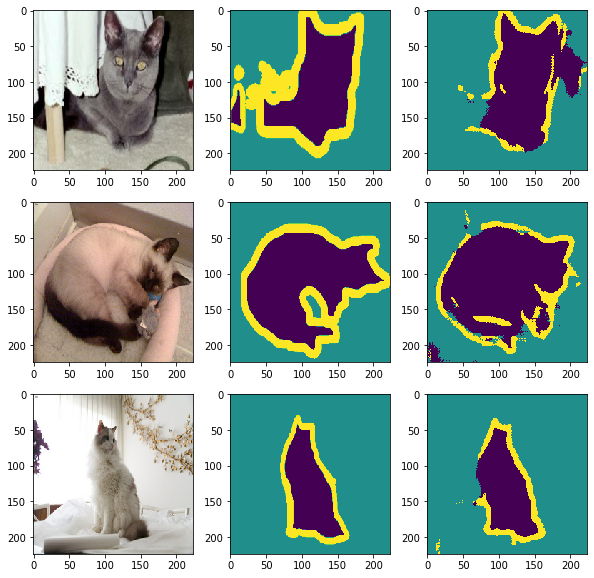

In [60]:
#预测就算了，能够保存这个模型，下次再继续使用就很好了！现在我们来看看预测的结果如何：

num=3
for image,mask in data_test.take(1):
    pred_mask=new_model.predict(image)
    pred_mask=tf.argmax(pred_mask,axis=-1)
    pred_mask=pred_mask[...,tf.newaxis]
    plt.figure(figsize=(10,10))
    for i in range(num):
        plt.subplot(num,3,i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num,3,i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num,3,i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))